## Bibliothèques 

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.integrate import quad, odeint
import seaborn
from tqdm import tqdm

## Fonctions génératrices de gaussiennes

In [2]:
## Step 1 - Generate G1,...Gd n i.i.d. samples following the law of G

def n_corr_gaussians():
    G = np.random.normal(0,1,d)
    G = G.reshape((-1,1))

    return G

def corr_guassians():

    C = np.array([[int(i==j)+ rho*int(i!=j) for i in range(d)] for j in range(d)])
    L = np.linalg.cholesky(C)
    G = np.random.normal(0,1,d*N)
    G = G.reshape((-1,1))

    rep_L = np.tile(L,(1,N))
    W_TN = (sqrt(h) * rep_L.dot(G)).reshape((-1,1))
    somme = np.linalg.norm(L)
    W_TN = W_TN / somme * T

    return W_TN

def corr_Gn():
    Gn_T = np.zeros((d,n))

    for i in range(n):
        W_TN = corr_guassians()
        Gn_T[:,i] = W_TN[:,-1]

    return Gn_T

def n_corr_Gn():
    Gn_T = np.zeros((d,n))

    for i in range(n):
        W_TN = n_corr_gaussians()
        Gn_T[:,i] = W_TN[:,-1]

    return Gn_T


def BS(S0, W_TN):

    W_TN = W_TN.reshape((-1,1))
    S_TN = S0 * np.exp((r-(sigmas**2)/2) * T + sigmas * W_TN)
    S_TN = S_TN.reshape((-1,1))

    return S_TN

## Calcul de l'espérance : 

In [3]:
## Step 2 - Compute the minimizer

def f(G_T):

    d_G, nb_G = np.shape(G_T)
    S_TN = np.zeros((d,nb_G))
    for i in range(nb_G):
        S_TN[:,i] = BS(S0, G_T[:,i]).reshape(-1)
    maxi = np.amax(K - portofolio.dot(S_TN), axis=0) #########################################################
    return np.where(maxi < 0, 0, maxi)

def grad_un_v (A, v, Gn_T):
    grad = (A.T).dot(A).dot(v).reshape((-1,1))
    temp = (f(Gn_T)**2).reshape((1,-1))
    somme = np.sum((A.T).dot(Gn_T) * temp * (np.exp(-(A.dot(v).reshape((-1,1))).T.dot(Gn_T)).reshape((1,-1))), axis=1)
    somme = somme / max(10,np.sum(temp * (np.exp(-(A.dot(v).reshape((-1,1))).T.dot(Gn_T)))))
    grad = grad - somme.reshape((-1,1))
    return grad

def hessian_un_v(A, v, Gn_T):
    hess = A.T.dot(A)
    temp = ((f(Gn_T)**2).reshape((1,-1)))
    somme1 = 0
    somme2 = 0
    somme3 = 0

    for i in range(n):
        Gi = Gn_T[:,i]
        Gi = Gi.reshape((-1,1))
        temp2 = (temp[0,i] * np.exp(-(A.dot(v).reshape((-1,1))).T.dot(Gi)))
        somme1 = somme1 + (A.T.dot(Gi).dot(Gi.T).dot(A)) * temp2
        somme2 = somme2 + temp2
        somme3 = somme3 + A.T.dot(Gi) * temp2
    somme2 = max(10e-6, somme2)
    hess = hess + somme1 /somme2 - somme3.dot(somme3.T) /((somme2)**2)
    return hess

# Newton's algorithm

def newton(A, x0, Gn_T, eps = 10**(-6)):
    xn_k = x0
    xn_k = xn_k.reshape((-1,1))
    k = 1
    g = grad_un_v(A, xn_k, Gn_T)

    nb_iter = 0
    while np.linalg.norm(g) > eps and nb_iter<15:
        h = hessian_un_v(A,xn_k,Gn_T)
        g = -grad_un_v(A,xn_k,Gn_T)
        d = np.linalg.inv(h).dot(g)
        #print("d\n", d)
        xn_k = xn_k + 1*d.reshape((-1,1))
        k += 1
        nb_iter += 1
        print("Norme du gradient :", np.linalg.norm(g))
    return xn_k

## Step 3 - Compute E[f(G)] by Monte Carlo

def expectation(Gn_T, A, x0, eps):

    xn = newton(A, x0, Gn_T, eps)
    xn = xn.reshape((-1,1))

    Mn = 0
    for i in range(n):
        Gi = Gn_T[:,i]
        Gi = Gi.reshape((-1,1))
        power = (A.dot(xn).T).dot(Gi/sqrt(T)) + np.linalg.norm(A.dot(xn))**2/2
        temp = f(Gi/sqrt(T) + A.dot(xn).reshape((-1,1))) * exp(-power)
        Mn += temp
    return exp(-r*T)/n*Mn

## Calcul de l'influence de r :

In [11]:
## Parameters :

d = 40              # actif
r = 0.05            # Facteur d'actualisation
T = 1               # maturite
S0 = 50             # Initialisation des modèles de BS
sigmas = np.array([[0.2] for i in range(d)])        # Sigma des modèles de BS
portofolio = np.array([[1/d for i in range(d)]])    # Répartition entre les différents BS
K = 55                                              # Strike
n = 5000                                           # Nombre de simulations pour Monte-Carlo
N = 100                                             # Nombre de points de discrétisation
rho = 0.1
h = sqrt(T/(N))


x0 = np.ones((d,1)).reshape((d,1))
A = np.identity(d)

print("Computing price with independant Brownian Motions... \n")
print("Computing of Gn ...")
G = n_corr_Gn()
print("Computing of E ...")
p1 = expectation(G,A,x0,10**(-6))
print("-> The price is {} \n".format(p1))

print("\n\n\n")
print("Computing price with correlated Brownian Motions... \n")
print("Computing of Gn ...")
Q = corr_Gn()
print("Computing of E ...")
p2 = expectation(Q,A,x0,10**(-6))
print("-> The price is {} \n".format(p2))


## Courbe d'influence de r :
print("\nInfluence de r :\n")

plt.figure()
r_s = np.linspace(0.03,0.1,2)
p_n_c = []
p_c = []
for i in tqdm(range(len(r_s))) :
    r = r_s[i]
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
plt.plot(r_s, p_n_c, label="Actifs non corrélés", )
plt.plot(r_s, p_c, label="Actifs corrélés")
plt.xlabel("r : taux d'actualisation", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.legend(fontsize=12)
plt.title("Influence du facteur d'actualisation sur le prix de l'option")
plt.savefig("r.eps", format='eps', dpi=1000)
plt.show()

Computing price with independant Brownian Motions... 

Computing of Gn ...
Computing of E ...
Norme du gradient : 10.6352258511
Norme du gradient : 5.15847154089
Norme du gradient : 0.990000798558
Norme du gradient : 0.0310813094703
Norme du gradient : 2.88091206158e-05
Norme du gradient : 3.28767646078e-11
-> The price is [ 2.3780425] 





Computing price with correlated Brownian Motions... 

Computing of Gn ...


KeyboardInterrupt: 

## Calcul de l'influence de K

  0%|          | 0/20 [00:00<?, ?it/s]


Influence du Strike K :

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


  5%|▌         | 1/20 [00:02<00:41,  2.16s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


 10%|█         | 2/20 [00:04<00:39,  2.18s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


 15%|█▌        | 3/20 [00:06<00:36,  2.15s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


 20%|██        | 4/20 [00:08<00:34,  2.16s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


 25%|██▌       | 5/20 [00:10<00:32,  2.15s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 6.32455532034
Norme du gradient : 0.0


 30%|███       | 6/20 [00:13<00:30,  2.20s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 10.3277320987
Norme du gradient : 4.40720217624
Norme du gradient : 0.0389745332938
Norme du gradient : 0.00725321160992
Norme du gradient : 0.00295061921871
Norme du gradient : 0.00234650730359
Norme du gradient : 0.0019965127294
Norme du gradient : 0.00170028252028
Norme du gradient : 0.00144858373043
Norme du gradient : 0.00123414950887
Norme du gradient : 0.00105151213602
Norme du gradient : 0.000895933339663
Norme du gradient : 0.000763397137957
Norme du gradient : 0.000650484022582
Norme du gradient : 0.000554284025038


 35%|███▌      | 7/20 [00:20<00:48,  3.76s/it]

Norme du gradient : 6.32455532034
Norme du gradient : 0.0
 
Norme du gradient : 10.2114259719
Norme du gradient : 3.6527273884
Norme du gradient : 1.09961469278
Norme du gradient : 1.14969224214
Norme du gradient : 1.72709804059
Norme du gradient : 1.74537354017
Norme du gradient : 1.69036716063
Norme du gradient : 1.71678048082
Norme du gradient : 1.69425158375
Norme du gradient : 1.72046833746
Norme du gradient : 1.69192483081
Norme du gradient : 1.71857353522
Norme du gradient : 1.6925197394
Norme du gradient : 1.71908076255
Norme du gradient : 1.69231035439


 40%|████      | 8/20 [00:28<01:00,  5.05s/it]

Norme du gradient : 10.1225371941
Norme du gradient : 3.28754226636
Norme du gradient : 0.842853702189
Norme du gradient : 0.646263076519
Norme du gradient : 0.434842943015
Norme du gradient : 0.370333298494
Norme du gradient : 0.282042477955
Norme du gradient : 0.255186662241
Norme du gradient : 0.205615992615
Norme du gradient : 0.188894180249
Norme du gradient : 0.155951024228
Norme du gradient : 0.143656224113
Norme du gradient : 0.120668164766
Norme du gradient : 0.11093656396
Norme du gradient : 0.0944534600717
 
Norme du gradient : 10.1522762842
Norme du gradient : 3.44664444039
Norme du gradient : 2.76005962236
Norme du gradient : 2.61711544181
Norme du gradient : 2.73090377797
Norme du gradient : 2.613440436
Norme du gradient : 2.73063425287
Norme du gradient : 2.61345323931
Norme du gradient : 2.73064334691
Norme du gradient : 2.61345223012
Norme du gradient : 2.7306431842
Norme du gradient : 2.61345221698
Norme du gradient : 2.73064319
Norme du gradient : 2.61345221571
Norme

 45%|████▌     | 9/20 [00:41<01:21,  7.45s/it]

Norme du gradient : 9.65808977934
Norme du gradient : 2.87343998885
Norme du gradient : 2.50297205036
Norme du gradient : 2.40726799391
Norme du gradient : 2.38618540533
Norme du gradient : 2.38570404374
Norme du gradient : 2.38817853925
Norme du gradient : 2.38472553964
Norme du gradient : 2.38852296458
Norme du gradient : 2.38469017554
Norme du gradient : 2.38847814462
Norme du gradient : 2.38468352842
Norme du gradient : 2.3884902699
Norme du gradient : 2.38468403225
Norme du gradient : 2.388487927
 
Norme du gradient : 10.1224933607
Norme du gradient : 3.27446230366
Norme du gradient : 2.10197637654
Norme du gradient : 1.34554457405
Norme du gradient : 1.41409389091
Norme du gradient : 1.3882836287
Norme du gradient : 1.44249553706
Norme du gradient : 1.38668240954
Norme du gradient : 1.44147356526
Norme du gradient : 1.38674466753
Norme du gradient : 1.4415132867
Norme du gradient : 1.38674222559
Norme du gradient : 1.44151172976
Norme du gradient : 1.38674232168
Norme du gradient

 50%|█████     | 10/20 [00:53<01:27,  8.72s/it]

Norme du gradient : 9.5616793365
Norme du gradient : 2.30543916076
Norme du gradient : 1.37287620924
Norme du gradient : 0.115669725871
Norme du gradient : 0.111193651549
Norme du gradient : 0.131602859522
Norme du gradient : 0.13193202507
Norme du gradient : 0.131406113629
Norme du gradient : 0.131786375899
Norme du gradient : 0.131407652996
Norme du gradient : 0.131787516494
Norme du gradient : 0.131407640943
Norme du gradient : 0.131787507563
Norme du gradient : 0.131407641037
Norme du gradient : 0.131787507633
 
Norme du gradient : 10.1054047751
Norme du gradient : 2.10778755943
Norme du gradient : 0.231943664782
Norme du gradient : 0.00167459663474
Norme du gradient : 9.6341306876e-08


 55%|█████▌    | 11/20 [01:02<01:20,  8.93s/it]

Norme du gradient : 9.52089877545
Norme du gradient : 1.91959929571
Norme du gradient : 0.134720768454
Norme du gradient : 0.00092282299961
Norme du gradient : 6.03619862738e-08
 
Norme du gradient : 10.094462271
Norme du gradient : 2.48134300681
Norme du gradient : 0.158932777338
Norme du gradient : 0.000923933412903
Norme du gradient : 3.36703119571e-08


 60%|██████    | 12/20 [01:07<01:01,  7.64s/it]

Norme du gradient : 9.49860402774
Norme du gradient : 2.26879211691
Norme du gradient : 0.173048670873
Norme du gradient : 0.00112548785679
Norme du gradient : 6.06128912681e-08
 
Norme du gradient : 10.0868879283
Norme du gradient : 2.97814733978
Norme du gradient : 0.322139009025
Norme du gradient : 0.004207882666
Norme du gradient : 7.73895365438e-07


 65%|██████▌   | 13/20 [01:11<00:45,  6.56s/it]

Norme du gradient : 9.48460085891
Norme du gradient : 2.6113694774
Norme du gradient : 0.240170222561
Norme du gradient : 0.00248571826473
Norme du gradient : 3.13958389703e-07
 
Norme du gradient : 10.081343825
Norme du gradient : 3.44174035653
Norme du gradient : 0.50614921902
Norme du gradient : 0.00969805905842
Norme du gradient : 4.11259264225e-06
Norme du gradient : 7.40296733242e-13


 70%|███████   | 14/20 [01:16<00:36,  6.01s/it]

Norme du gradient : 9.4750030779
Norme du gradient : 2.96870505208
Norme du gradient : 0.31267143339
Norme du gradient : 0.00381197928392
Norme du gradient : 7.02844410246e-07
 
Norme du gradient : 10.0771137753
Norme du gradient : 3.8956390926
Norme du gradient : 0.699133359226
Norme du gradient : 0.0143539224712
Norme du gradient : 7.88397646122e-06
Norme du gradient : 2.38916891389e-12


 75%|███████▌  | 15/20 [01:22<00:30,  6.17s/it]

Norme du gradient : 9.46801900703
Norme du gradient : 3.30776610427
Norme du gradient : 0.400485881419
Norme du gradient : 0.00456359068258
Norme du gradient : 8.58744631639e-07
 
Norme du gradient : 10.0737816566
Norme du gradient : 4.32055133939
Norme du gradient : 0.880093689132
Norme du gradient : 0.016382886804
Norme du gradient : 8.34675348314e-06
Norme du gradient : 2.19861296299e-12


 80%|████████  | 16/20 [01:27<00:23,  5.83s/it]

Norme du gradient : 9.46271077018
Norme du gradient : 3.5875406199
Norme du gradient : 0.468991812967
Norme du gradient : 0.00512157244473
Norme du gradient : 9.82166686e-07
 
Norme du gradient : 10.0710897387
Norme du gradient : 4.71335535639
Norme du gradient : 1.0084896251
Norme du gradient : 0.0151132800431
Norme du gradient : 5.38216042954e-06
Norme du gradient : 7.28658452142e-13


 85%|████████▌ | 17/20 [01:32<00:16,  5.51s/it]

Norme du gradient : 9.45854062808
Norme du gradient : 3.83372263363
Norme du gradient : 0.473460969204
Norme du gradient : 0.00579921989322
Norme du gradient : 1.28657447226e-06
Norme du gradient : 7.28524464688e-14
 
Norme du gradient : 10.0688700787
Norme du gradient : 5.05770008571
Norme du gradient : 1.08414073175
Norme du gradient : 0.0130752900948
Norme du gradient : 2.65127933381e-06
Norme du gradient : 1.35857233166e-13


 90%|█████████ | 18/20 [01:40<00:12,  6.12s/it]

Norme du gradient : 9.45517841124
Norme du gradient : 4.01209267248
Norme du gradient : 0.538561684752
Norme du gradient : 0.00767500102346
Norme du gradient : 2.1424237671e-06
Norme du gradient : 1.94710509644e-13
 
Norme du gradient : 10.0670086385
Norme du gradient : 5.38169002458
Norme du gradient : 1.05916681486
Norme du gradient : 0.0111638728409
Norme du gradient : 1.64911471072e-06
Norme du gradient : 4.26286719927e-14


 95%|█████████▌| 19/20 [01:46<00:06,  6.23s/it]

Norme du gradient : 9.45241028015
Norme du gradient : 4.13339316431
Norme du gradient : 0.618427168682
Norme du gradient : 0.0101385424943
Norme du gradient : 3.41734193837e-06
Norme du gradient : 4.74606740102e-13
 
Norme du gradient : 10.0654253028
Norme du gradient : 5.63768062618
Norme du gradient : 1.27788874169
Norme du gradient : 0.0146040259006
Norme du gradient : 1.7204271805e-06
Norme du gradient : 3.86080833136e-14


100%|██████████| 20/20 [01:53<00:00,  6.57s/it]


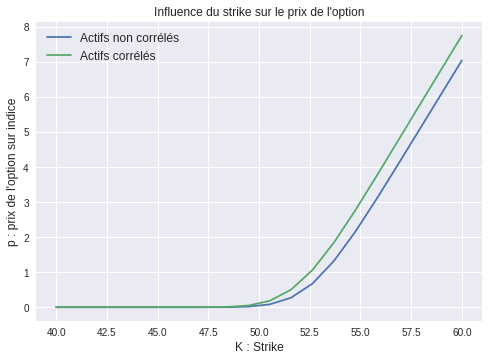

In [63]:
## Courbe d'influence de K :

print("\nInfluence du Strike K :\n")

plt.figure()
r = 0.05
K_s = np.linspace(0.8*S0, 1.2*S0,20)
p_n_c = []
p_c = []
for i in tqdm(range(len(K_s))) :
    K = K_s[i]
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
plt.plot(K_s, p_n_c, label="Actifs non corrélés", )
plt.plot(K_s, p_c, label="Actifs corrélés")
plt.xlabel("K : Strike", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.legend(fontsize=12)
plt.title("Influence du strike sur le prix de l'option")
plt.savefig('K.eps', format='eps', dpi=1000)
plt.show()

## Calcul de l'influence de sigmas :

  0%|          | 0/20 [00:00<?, ?it/s]


Influence de sigma :

Norme du gradient : 9.42388359535
Norme du gradient : 4.53629313974
Norme du gradient : 1.18332633084
Norme du gradient : 0.0342853560484
Norme du gradient : 2.93364989185e-05
Norme du gradient : 2.7931188491e-11
 
Norme du gradient : 10.0458496976
Norme du gradient : 6.21363409148
Norme du gradient : 2.83164286593
Norme du gradient : 0.164316353441
Norme du gradient : 0.000237912401242
Norme du gradient : 6.86763376336e-10


  5%|▌         | 1/20 [00:06<02:08,  6.76s/it]

Norme du gradient : 9.4519335828
Norme du gradient : 4.28487803436
Norme du gradient : 0.793307392397
Norme du gradient : 0.0157416331446
Norme du gradient : 7.44930438219e-06
Norme du gradient : 2.1086529918e-12
 
Norme du gradient : 10.0667121868
Norme du gradient : 5.85280481991
Norme du gradient : 1.66184131003
Norme du gradient : 0.0284863037757
Norme du gradient : 3.39284705526e-06
Norme du gradient : 7.14798187562e-14


 10%|█         | 2/20 [00:12<01:58,  6.56s/it]

Norme du gradient : 9.46401830095
Norme du gradient : 3.69162663671
Norme du gradient : 0.494728288438
Norme du gradient : 0.00586116144008
Norme du gradient : 1.27686304771e-06
Norme du gradient : 7.20193213532e-14
 
Norme du gradient : 10.0735294373
Norme du gradient : 4.72223814614
Norme du gradient : 1.0073099086
Norme du gradient : 0.0149483899675
Norme du gradient : 5.2193500151e-06
Norme du gradient : 6.81576393898e-13


 15%|█▌        | 3/20 [00:18<01:45,  6.22s/it]

Norme du gradient : 9.47019025627
Norme du gradient : 3.27109060732
Norme du gradient : 0.392964108044
Norme du gradient : 0.00455763355825
Norme du gradient : 8.67636798098e-07
 
Norme du gradient : 10.0758210077
Norme du gradient : 4.20023840545
Norme du gradient : 0.834887090937
Norme du gradient : 0.0161660417556
Norme du gradient : 8.67102884569e-06
Norme du gradient : 2.52155880487e-12


 20%|██        | 4/20 [00:23<01:36,  6.01s/it]

Norme du gradient : 9.47359392341
Norme du gradient : 3.01708290131
Norme du gradient : 0.322373970283
Norme du gradient : 0.00390438854876
Norme du gradient : 7.27258101436e-07
 
Norme du gradient : 10.0761858976
Norme du gradient : 3.9714224259
Norme du gradient : 0.736044384647
Norme du gradient : 0.015053875392
Norme du gradient : 8.39597230772e-06
Norme du gradient : 2.62636767313e-12


 25%|██▌       | 5/20 [00:29<01:28,  5.90s/it]

Norme du gradient : 9.47554586357
Norme du gradient : 2.86134448576
Norme du gradient : 0.293531519451
Norme du gradient : 0.00362455433792
Norme du gradient : 6.57505291594e-07
 
Norme du gradient : 10.0756131187
Norme du gradient : 3.8692994268
Norme du gradient : 0.685294202558
Norme du gradient : 0.0140661250928
Norme du gradient : 7.65156360889e-06
Norme du gradient : 2.27349957093e-12


 30%|███       | 6/20 [00:36<01:27,  6.23s/it]

Norme du gradient : 9.47670837247
Norme du gradient : 2.76832577895
Norme du gradient : 0.273919713259
Norme du gradient : 0.00327087488322
Norme du gradient : 5.48268511187e-07
 
Norme du gradient : 10.0745556161
Norme du gradient : 3.83145339795
Norme du gradient : 0.667419502996
Norme du gradient : 0.0137047010677
Norme du gradient : 7.37115177342e-06
Norme du gradient : 2.14020858504e-12


 35%|███▌      | 7/20 [00:43<01:25,  6.61s/it]

Norme du gradient : 9.47746123021
Norme du gradient : 2.71031368111
Norme du gradient : 0.261162438129
Norme du gradient : 0.00298748339629
Norme du gradient : 4.62593307952e-07
 
Norme du gradient : 10.073246557
Norme du gradient : 3.8322505311
Norme du gradient : 0.666449275283
Norme du gradient : 0.01367486796
Norme du gradient : 7.33602680714e-06
Norme du gradient : 2.11894521242e-12


 40%|████      | 8/20 [00:49<01:16,  6.36s/it]

Norme du gradient : 9.47804480712
Norme du gradient : 2.67469884788
Norme du gradient : 0.25403083481
Norme du gradient : 0.00281391789926
Norme du gradient : 4.13719908821e-07
 
Norme du gradient : 10.0718157072
Norme du gradient : 3.85747627225
Norme du gradient : 0.675851644063
Norme du gradient : 0.0138461564287
Norme du gradient : 7.44782783527e-06
Norme du gradient : 2.16334349255e-12


 45%|████▌     | 9/20 [00:54<01:05,  5.96s/it]

Norme du gradient : 9.47862293805
Norme du gradient : 2.65481001666
Norme du gradient : 0.250308392454
Norme du gradient : 0.00271892189753
Norme du gradient : 3.89349317256e-07
 
Norme du gradient : 10.070339179
Norme du gradient : 3.89899142033
Norme du gradient : 0.692176317954
Norme du gradient : 0.0141353636264
Norme du gradient : 7.63540673289e-06
Norme du gradient : 2.23749989445e-12


 50%|█████     | 10/20 [01:00<00:57,  5.76s/it]

Norme du gradient : 9.47931326352
Norme du gradient : 2.64682094824
Norme du gradient : 0.248764598708
Norme du gradient : 0.00267847444841
Norme du gradient : 3.80973853042e-07
 
Norme du gradient : 10.0688631398
Norme du gradient : 3.95180668457
Norme du gradient : 0.713257177436
Norme du gradient : 0.0144853753886
Norme du gradient : 7.84600549347e-06
Norme du gradient : 2.31340326303e-12


 55%|█████▌    | 11/20 [01:05<00:51,  5.71s/it]

Norme du gradient : 9.48020275784
Norme du gradient : 2.64792544722
Norme du gradient : 0.249131335324
Norme du gradient : 0.00268882600023
Norme du gradient : 3.87444397669e-07
 
Norme du gradient : 10.067416084
Norme du gradient : 4.01200974611
Norme du gradient : 0.739161856742
Norme du gradient : 0.0149199169158
Norme du gradient : 8.11280819322e-06
Norme du gradient : 2.41292258104e-12


 60%|██████    | 12/20 [01:11<00:46,  5.87s/it]

Norme du gradient : 9.48135596916
Norme du gradient : 2.65641096665
Norme du gradient : 0.251173902743
Norme du gradient : 0.0027397595189
Norme du gradient : 4.05816297261e-07
 
Norme du gradient : 10.0660156122
Norme du gradient : 4.07724048962
Norme du gradient : 0.769034583474
Norme du gradient : 0.0154222361267
Norme du gradient : 8.42149191837e-06
Norme du gradient : 2.52891905746e-12


 65%|██████▌   | 13/20 [01:16<00:38,  5.55s/it]

Norme du gradient : 9.48281951414
Norme du gradient : 2.67072218933
Norme du gradient : 0.254955014538
Norme du gradient : 0.00282704511095
Norme du gradient : 4.35353744952e-07
 
Norme du gradient : 10.0646723766
Norme du gradient : 4.14616827803
Norme du gradient : 0.800546704221
Norme du gradient : 0.0159341645526
Norme du gradient : 8.70963395145e-06
Norme du gradient : 2.62406185063e-12


 70%|███████   | 14/20 [01:23<00:35,  5.89s/it]

Norme du gradient : 9.48462445879
Norme du gradient : 2.68955950168
Norme du gradient : 0.260521162152
Norme du gradient : 0.00295003192366
Norme du gradient : 4.76827004584e-07
 
Norme du gradient : 10.0633924789
Norme du gradient : 4.21905491865
Norme du gradient : 0.829406005117
Norme du gradient : 0.0163014565205
Norme du gradient : 8.80402390845e-06
Norme du gradient : 2.59303316167e-12


 75%|███████▌  | 15/20 [01:28<00:28,  5.62s/it]

Norme du gradient : 9.4867874218
Norme du gradient : 2.71178115678
Norme du gradient : 0.267844883737
Norme du gradient : 0.00310914518619
Norme du gradient : 5.3179179027e-07
 
Norme du gradient : 10.0621789804
Norme du gradient : 4.294329947
Norme du gradient : 0.857940030198
Norme du gradient : 0.0165920082713
Norme du gradient : 8.7886447762e-06
Norme du gradient : 2.49319301033e-12


 80%|████████  | 16/20 [01:33<00:21,  5.45s/it]

Norme du gradient : 9.48931097081
Norme du gradient : 2.7365966475
Norme du gradient : 0.276959218383
Norme du gradient : 0.00331085798572
Norme du gradient : 6.04712611253e-07
 
Norme du gradient : 10.0610328832
Norme du gradient : 4.37027396589
Norme du gradient : 0.888249620374
Norme du gradient : 0.0168178254623
Norme du gradient : 8.68164000896e-06
Norme du gradient : 2.34407890537e-12


 85%|████████▌ | 17/20 [01:39<00:17,  5.71s/it]

Norme du gradient : 9.49218387531
Norme du gradient : 2.76344745345
Norme du gradient : 0.287548946943
Norme du gradient : 0.0035484283759
Norme du gradient : 6.95431957571e-07
 
Norme du gradient : 10.0599537842
Norme du gradient : 4.44771390669
Norme du gradient : 0.916750504809
Norme du gradient : 0.0168341781723
Norme du gradient : 8.33575116213e-06
Norme du gradient : 2.07827403212e-12


 90%|█████████ | 18/20 [01:44<00:10,  5.36s/it]

Norme du gradient : 9.49538425204
Norme du gradient : 2.79352656991
Norme du gradient : 0.297444441908
Norme du gradient : 0.00372498757513
Norme du gradient : 7.62009767852e-07
 
Norme du gradient : 10.0589403204
Norme du gradient : 4.52564647535
Norme du gradient : 0.946382033266
Norme du gradient : 0.0168055352512
Norme du gradient : 7.93401568394e-06
Norme du gradient : 1.80718610586e-12


 95%|█████████▌| 19/20 [01:51<00:05,  5.80s/it]

Norme du gradient : 9.49888037478
Norme du gradient : 2.82647284705
Norme du gradient : 0.307505506923
Norme du gradient : 0.00385462985818
Norme du gradient : 8.04906548971e-07
 
Norme du gradient : 10.0579904795
Norme du gradient : 4.60340393783
Norme du gradient : 0.974183498475
Norme du gradient : 0.0166475515386
Norme du gradient : 7.4138023311e-06
Norme du gradient : 1.51243208899e-12


100%|██████████| 20/20 [01:55<00:00,  5.42s/it]


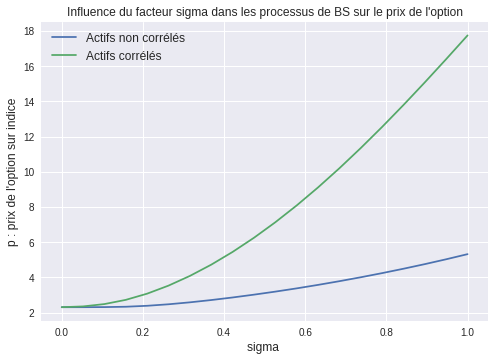

In [64]:
## Courbe d'influence de sigams :

print("\nInfluence de sigma :\n")

plt.figure()
r = 0.05
K = 55
sigma_s = np.linspace(0, 1,20)
p_n_c = []
p_c = []
for i in tqdm(range(len(K_s))) :
    sigma = sigma_s[i]
    sigmas = np.array([[sigma] for i in range(d)])
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
plt.plot(sigma_s, p_n_c, label="Actifs non corrélés", )
plt.plot(sigma_s, p_c, label="Actifs corrélés")
plt.xlabel("sigma ", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.legend(fontsize=12)
plt.title("Influence du facteur sigma dans les processus de BS sur le prix de l'option")
plt.savefig('sigma.eps', format='eps', dpi=1000)
plt.show()

## Calcul de l'influence du nombre d'actifs


  0%|          | 0/20 [00:00<?, ?it/s]


Influence du nombre d'actifs :



Norme du gradient : 2.88000008217
Norme du gradient : 0.22216333967
Norme du gradient : 0.00162439451342
Norme du gradient : 8.65554602436e-08
 
Norme du gradient : 10.0088701945
Norme du gradient : 0.0331239512224
Norme du gradient : 0.000127030441891
Norme du gradient : 1.86846293992e-09



  5%|▌         | 1/20 [00:05<01:45,  5.55s/it]

Norme du gradient : 5.48664623558


Norme du gradient : 0.830133883109
Norme du gradient : 0.00705004465445
Norme du gradient : 1.10515445339e-06
Norme du gradient : 4.39223718754e-14
 
Norme du gradient : 14.748937149
Norme du gradient : 9.94799106669
Norme du gradient : 4.92453038267
Norme du gradient : 1.46373639475
Norme du gradient : 0.224306400029
Norme du gradient : 0.00613496926367
Norme du gradient : 4.66382420526e-06
Norme du gradient : 2.69613542393e-12


 10%|█         | 2/20 [00:16<02:06,  7.04s/it]

Norme du gradient : 6.2649452217
Norme du gradient : 1.31774221206
Norme du gradient : 0.0486469273974
Norme du gradient : 8.39541904567e-05
Norme du gradient : 2.56725604453e-10
 
Norme du gradient : 14.0000592331
Norme du gradient : 9.60754651813
Norme du gradient : 6.12374230861
Norme du gradient : 1.49822754376
Norme du gradient : 0.215921088126
Norme du gradient : 0.00567100427785
Norme du gradient : 4.04933556367e-06
Norme du gradient : 2.06642480967e-12


 15%|█▌        | 3/20 [00:31<02:41,  9.50s/it]

Norme du gradient : 7.85401119238
Norme du gradient : 2.48397399482
Norme du gradient : 0.206737053875
Norme du gradient : 0.0015458065159
Norme du gradient : 9.01111909778e-08
 
Norme du gradient : 14.711081427
Norme du gradient : 10.6340888414
Norme du gradient : 7.60557716059
Norme du gradient : 0.670642469547
Norme du gradient : 0.0468914536784
Norme du gradient : 0.000276390389683
Norme du gradient : 9.67281210096e-09


 20%|██        | 4/20 [00:44<02:50, 10.64s/it]

Norme du gradient : 8.07512532895
Norme du gradient : 2.71939936266
Norme du gradient : 0.246076027322
Norme du gradient : 0.00190523401526
Norme du gradient : 1.22221097765e-07
 
Norme du gradient : 16.5344370077
Norme du gradient : 13.0504494444
Norme du gradient : 10.2472745775
Norme du gradient : 0.845865360008
Norme du gradient : 0.00087538532982
Norme du gradient : 8.65665306268e-08


 25%|██▌       | 5/20 [01:02<03:12, 12.85s/it]

Norme du gradient : 10.041821377
Norme du gradient : 5.81396904454
Norme du gradient : 1.09571937361
Norme du gradient : 0.0444639791064
Norme du gradient : 6.4641138393e-05
Norme du gradient : 1.47785428518e-10
 
Norme du gradient : 16.2949843578
Norme du gradient : 12.0577590861
Norme du gradient : 10.1920258126
Norme du gradient : 1.36825894891
Norme du gradient : 0.242298814043
Norme du gradient : 0.00720123779632
Norme du gradient : 6.70781811871e-06
Norme du gradient : 5.82909014085e-12


 30%|███       | 6/20 [01:25<03:41, 15.82s/it]

Norme du gradient : 9.99734900262
Norme du gradient : 3.92947182407
Norme du gradient : 0.45924991073
Norme du gradient : 0.00676043518739
Norme du gradient : 1.59673724714e-06
Norme du gradient : 9.28730291984e-14
 
Norme du gradient : 16.5067802366
Norme du gradient : 11.9830929002
Norme du gradient : 10.315293781
Norme du gradient : 2.36491895324
Norme du gradient : 0.92604316525
Norme du gradient : 0.0845812022816
Norme du gradient : 0.000845730469828
Norme du gradient : 8.60713907543e-08


 35%|███▌      | 7/20 [01:49<03:56, 18.19s/it]

Norme du gradient : 9.50996753324
Norme du gradient : 3.41044065456
Norme du gradient : 0.400403698005
Norme du gradient : 0.00475241982895
Norme du gradient : 7.32026343194e-07
 
Norme du gradient : 19.28898122
Norme du gradient : 14.9510870324
Norme du gradient : 14.3769633331
Norme du gradient : 6.85644508651
Norme du gradient : 10.0467589476
Norme du gradient : 2.39354680042
Norme du gradient : 0.38083399816
Norme du gradient : 0.0163430443637
Norme du gradient : 3.27075175359e-05
Norme du gradient : 1.31483861749e-10


 40%|████      | 8/20 [02:21<04:29, 22.42s/it]

Norme du gradient : 10.508776808
Norme du gradient : 3.74467685458
Norme du gradient : 0.471746878334
Norme du gradient : 0.00679221680428
Norme du gradient : 1.52312333168e-06
Norme du gradient : 8.01244748456e-14
 
Norme du gradient : 17.636385807
Norme du gradient : 12.8142888958
Norme du gradient : 11.8383402384
Norme du gradient : 4.7895888645
Norme du gradient : 5.31807513824
Norme du gradient : 1.06180980877
Norme du gradient : 0.105679632359
Norme du gradient : 0.0013044330651
Norme du gradient : 2.03328772891e-07


 45%|████▌     | 9/20 [03:08<05:27, 29.81s/it]

Norme du gradient : 11.4136775221
Norme du gradient : 4.46899921154
Norme du gradient : 0.641729513162
Norme du gradient : 0.0101058209146
Norme du gradient : 2.98898372612e-06
Norme du gradient : 3.00506646019e-13
 
Norme du gradient : 18.5726449539
Norme du gradient : 13.5440589937
Norme du gradient : 12.9019216712
Norme du gradient : 6.46400928698
Norme du gradient : 9.46092285133
Norme du gradient : 1.1083207739
Norme du gradient : 0.0809531372597
Norme du gradient : 0.000737820201708
Norme du gradient : 6.24513273495e-08


 50%|█████     | 10/20 [03:48<05:29, 32.99s/it]

Norme du gradient : 12.9519924239
Norme du gradient : 5.4267513032
Norme du gradient : 1.16891543898
Norme du gradient : 0.039886439204
Norme du gradient : 4.43377683066e-05
Norme du gradient : 6.84272750288e-11
 
Norme du gradient : 19.0256905139
Norme du gradient : 13.8331813797
Norme du gradient : 12.9571713841
Norme du gradient : 7.3037464691
Norme du gradient : 10.7705057914
Norme du gradient : 1.79531840086
Norme du gradient : 0.370063866654
Norme du gradient : 0.0147195936166
Norme du gradient : 2.51137191777e-05
Norme du gradient : 7.33299475761e-11


 55%|█████▌    | 11/20 [04:38<05:41, 37.92s/it]

Norme du gradient : 12.6846106237
Norme du gradient : 5.22010941017
Norme du gradient : 1.15423240202
Norme du gradient : 0.0364898050422
Norme du gradient : 3.05055909636e-05
Norme du gradient : 2.37813849954e-11
 
Norme du gradient : 18.3621412086
Norme du gradient : 12.5045119837
Norme du gradient : 11.9885735137
Norme du gradient : 7.58499009421
Norme du gradient : 10.7649067757
Norme du gradient : 3.58791312438
Norme du gradient : 3.13458412469
Norme du gradient : 0.547520363425
Norme du gradient : 0.0314293468307
Norme du gradient : 0.000117502431652
Norme du gradient : 1.65481160536e-09


 60%|██████    | 12/20 [05:32<05:41, 42.74s/it]

Norme du gradient : 12.6261105892
Norme du gradient : 5.84759063223
Norme du gradient : 1.61339838006
Norme du gradient : 0.136204873607
Norme du gradient : 0.000423301323529
Norme du gradient : 4.9713502843e-09
 
Norme du gradient : 18.6905088513
Norme du gradient : 12.8126738048
Norme du gradient : 12.1731322019
Norme du gradient : 7.86393588399
Norme du gradient : 10.9400343946
Norme du gradient : 4.11146725858
Norme du gradient : 4.61987382234
Norme du gradient : 0.825117882109
Norme du gradient : 0.0625764607694
Norme du gradient : 0.000428569524641
Norme du gradient : 2.0392891918e-08


 65%|██████▌   | 13/20 [06:37<05:45, 49.38s/it]

Norme du gradient : 15.1404207534
Norme du gradient : 7.27003827067
Norme du gradient : 8.59391264977
Norme du gradient : 1.44713611852
Norme du gradient : 0.0930091390103
Norme du gradient : 0.000223975697175
Norme du gradient : 1.35765429393e-09
 
Norme du gradient : 20.5067998835
Norme du gradient : 14.6827327158
Norme du gradient : 14.1483867798
Norme du gradient : 10.8989792035
Norme du gradient : 13.7726252921
Norme du gradient : 9.23996782898
Norme du gradient : 13.4055567953
Norme du gradient : 7.54024538917
Norme du gradient : 12.5564343298
Norme du gradient : 4.41138552914
Norme du gradient : 5.24982694423
Norme du gradient : 1.0604866351
Norme du gradient : 0.0940282570746
Norme du gradient : 0.000945618297723
Norme du gradient : 9.79983022439e-08


 70%|███████   | 14/20 [07:53<05:45, 57.62s/it]

Norme du gradient : 14.4525284527
Norme du gradient : 10.6040657101
Norme du gradient : 10.5430090059
Norme du gradient : 10.647292747
Norme du gradient : 10.5530499859
Norme du gradient : 10.6518660752
Norme du gradient : 10.5540074846
Norme du gradient : 10.6522144892
Norme du gradient : 10.5540898762
Norme du gradient : 10.6522442001
Norme du gradient : 10.554099645
Norme du gradient : 10.6522466539
Norme du gradient : 10.5541009704
Norme du gradient : 10.6522468666
Norme du gradient : 10.554101177
 
Norme du gradient : 20.9335197501
Norme du gradient : 14.8501748354
Norme du gradient : 14.4996772503
Norme du gradient : 12.3879706077
Norme du gradient : 14.293694908
Norme du gradient : 11.565116808
Norme du gradient : 14.1975293698
Norme du gradient : 11.1329565268
Norme du gradient : 14.1393908656
Norme du gradient : 10.8595189961
Norme du gradient : 14.099375783
Norme du gradient : 10.6667904259
Norme du gradient : 14.0694832092
Norme du gradient : 10.5207147445
Norme du gradient 

 75%|███████▌  | 15/20 [09:26<05:40, 68.04s/it]

Norme du gradient : 14.143694889
Norme du gradient : 6.62933183111
Norme du gradient : 2.29525180235
Norme du gradient : 0.400196414767
Norme du gradient : 0.00536790636822
Norme du gradient : 9.08233469817e-07
 
Norme du gradient : 20.4843013332
Norme du gradient : 14.2369611505
Norme du gradient : 13.6968546901
Norme du gradient : 10.4082604434
Norme du gradient : 13.172030477
Norme du gradient : 8.32407789642
Norme du gradient : 12.4308366257
Norme du gradient : 5.69837396039
Norme du gradient : 9.04710053182
Norme du gradient : 0.558192257795
Norme du gradient : 0.00205187273351
Norme du gradient : 4.29030203684e-07


 80%|████████  | 16/20 [10:54<04:56, 74.11s/it]

Norme du gradient : 13.4529836543
Norme du gradient : 6.15816494275
Norme du gradient : 2.0750827972
Norme du gradient : 0.280626890405
Norme du gradient : 0.00307497665676
Norme du gradient : 3.51989775159e-07
 
Norme du gradient : 21.6357015379
Norme du gradient : 15.2172569909
Norme du gradient : 14.885909655
Norme du gradient : 13.5708090962
Norme du gradient : 14.7854906094
Norme du gradient : 13.199465341
Norme du gradient : 14.7571258965
Norme du gradient : 13.0835977384
Norme du gradient : 14.7477495975
Norme du gradient : 13.0442415957
Norme du gradient : 14.7445047357
Norme du gradient : 13.0305000898
Norme du gradient : 14.7433644649
Norme du gradient : 13.0256564058
Norme du gradient : 14.7429616294


 85%|████████▌ | 17/20 [12:28<04:00, 80.13s/it]

Norme du gradient : 14.5620945174
Norme du gradient : 7.11047132053
Norme du gradient : 4.06886744185
Norme du gradient : 1.18146417789
Norme du gradient : 0.148137919156
Norme du gradient : 0.000826550343376
Norme du gradient : 2.53979717646e-08
 
Norme du gradient : 21.8514693874
Norme du gradient : 15.2421306463
Norme du gradient : 14.774156471
Norme du gradient : 12.6921635047
Norme du gradient : 14.5863356365
Norme du gradient : 12.209074669
Norme du gradient : 14.536668297
Norme du gradient : 12.0687393126
Norme du gradient : 14.5211537481
Norme du gradient : 12.0238278787
Norme du gradient : 14.5160771878
Norme du gradient : 12.0090217743
Norme du gradient : 14.5143914512
Norme du gradient : 12.0040931906
Norme du gradient : 14.5138289667


 90%|█████████ | 18/20 [14:17<02:57, 88.84s/it]

Norme du gradient : 15.4321834533
Norme du gradient : 7.11679087104
Norme du gradient : 3.39227176689
Norme du gradient : 0.870401298038
Norme du gradient : 0.0622134646762
Norme du gradient : 0.000128954038546
Norme du gradient : 5.76281400842e-10
 
Norme du gradient : 21.1392773748
Norme du gradient : 14.2949123861
Norme du gradient : 13.7773103902
Norme du gradient : 11.5794018992
Norme du gradient : 13.5021569052
Norme du gradient : 10.9550262045
Norme du gradient : 13.4052671021
Norme du gradient : 10.7101658766
Norme du gradient : 13.3625955141
Norme du gradient : 10.5980058651
Norme du gradient : 13.3420832544
Norme du gradient : 10.5431382775
Norme du gradient : 13.3318182319
Norme du gradient : 10.5154475719
Norme du gradient : 13.3265789351


 95%|█████████▌| 19/20 [16:12<01:36, 96.44s/it]

Norme du gradient : 13.9744788533
Norme du gradient : 5.66898139231
Norme du gradient : 1.49217082759
Norme du gradient : 0.0676920106095
Norme du gradient : 9.29431066726e-05
Norme du gradient : 2.10428938726e-10
 
Norme du gradient : 20.8553607141
Norme du gradient : 13.8206879903
Norme du gradient : 13.057154809
Norme du gradient : 10.2694362586
Norme du gradient : 12.5517983681
Norme du gradient : 9.25884633272
Norme du gradient : 12.2946491821
Norme du gradient : 8.64947145898
Norme du gradient : 12.0931049228
Norme du gradient : 8.13543364903
Norme du gradient : 11.8822931869
Norme du gradient : 7.57394605867
Norme du gradient : 11.5902947395
Norme du gradient : 6.77844833314
Norme du gradient : 10.9992236666


100%|██████████| 20/20 [18:13<00:00, 104.02s/it]


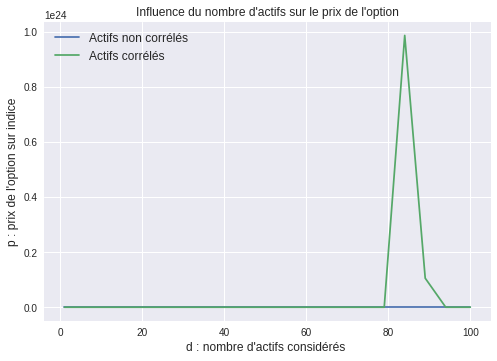

In [15]:
## Courbe d'influence de la dimension :

print("\nInfluence du nombre d'actifs :\n")

plt.figure()
r = 0.05
K = 55
d_s =  np.array(np.linspace(1,100, 20), dtype=int)
p_n_c = []
p_c = []
for i in tqdm(range(len(d_s))) :
    d = d_s[i]
    A = np.identity(d)
    x0 = np.ones((d,1)).reshape((d,1))
    sigmas = np.array([[0.2] for i in range(d)])        # Sigma des modèles de BS
    portofolio = np.array([[1/d for i in range(d)]])
    G = n_corr_Gn()
    Q = corr_Gn()
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
    
## Convert
p_n_c = np.array(p_n_c)
p_c = np.array(p_c)
p_n_c = np.where(p_n_c < 1, np.mean(p_n_c), p_n_c)
p_c = np.where(p_c < 1, np.mean(p_c), p_c)
    
plt.plot(d_s, p_n_c, label="Actifs non corrélés", )
plt.plot(d_s, p_c, label="Actifs corrélés")
plt.xlabel("d : nombre d'actifs considérés ", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.legend(fontsize=12)
plt.title("Influence du nombre d'actifs sur le prix de l'option")
plt.savefig('d.eps', format='eps', dpi=1000)
plt.show()

## Calcul de l'influence du nombre de pas de discrètisation

  0%|          | 0/1 [00:00<?, ?it/s]


Influence du nombre de N :

N 2000
Norme du gradient : 11.6974683749
Norme du gradient : 4.31990224342
Norme du gradient : 0.547510800598
Norme du gradient : 0.00795197513063
Norme du gradient : 2.02751086473e-06
Norme du gradient : 1.42958958025e-13
 
Norme du gradient : 11.049270693
Norme du gradient : 4.6926905325
Norme du gradient : 0.758110174687
Norme du gradient : 0.0183009010319
Norme du gradient : 1.23333478281e-05
Norme du gradient : 6.15305511341e-12


100%|██████████| 1/1 [01:34<00:00, 94.86s/it]

[ 2.38062749]
[ 2.2241159]


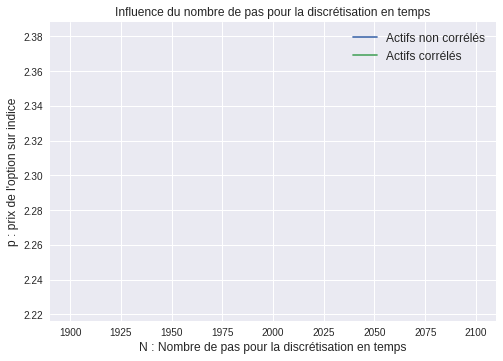

In [28]:
## Courbe d'influence de N:

print("\nInfluence du nombre de N :\n")

plt.figure()
r = 0.05
K = 55
d = 40
sigmas = np.array([[0.2] for i in range(d)])
A = np.identity(d)
x0 = np.ones((d,1)).reshape((d,1))
sigmas = np.array([[0.2] for i in range(d)])        # Sigma des modèles de BS
portofolio = np.array([[1/d for i in range(d)]])
N_s = [2000]
p_n_c = []
p_c = []
for i in tqdm(range(len(N_s))) :
    N = N_s[i]
    print("N",N)
    h = sqrt(T/(N))
    G = n_corr_Gn()
    Q = corr_Gn()
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
    print(p1)
    print(p2)
    
## Convert
p_n_c = np.array(p_n_c)
p_c = np.array(p_c)
p_n_c = np.where(p_n_c < 1, np.mean(p_n_c), p_n_c)
p_c = np.where(p_c < 1, np.mean(p_c), p_c)

plt.plot(N_s, p_n_c, label="Actifs non corrélés", )
plt.plot(N_s, p_c, label="Actifs corrélés")
plt.xlabel("N : Nombre de pas pour la discrétisation en temps", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.legend(fontsize=12)
plt.title("Influence du nombre de pas pour la discrétisation en temps")
plt.savefig('N.eps', format='eps', dpi=1000)
plt.show()

## Influence de rho :

  0%|          | 0/1 [00:00<?, ?it/s]


Influence du nombre de rho :

Norme du gradient : 11.4411669083
Norme du gradient : 5.87144600621
Norme du gradient : 1.30386539644
Norme du gradient : 0.0316568877819
Norme du gradient : 1.71179695659e-05
Norme du gradient : 6.50964900663e-12
 
Norme du gradient : 6.88915484978
Norme du gradient : 0.276182874587
Norme du gradient : 7.53119031692e-05
Norme du gradient : 7.74655085708e-12


100%|██████████| 1/1 [00:20<00:00, 20.53s/it]

[ 2.361491]
[ 3.31536597]


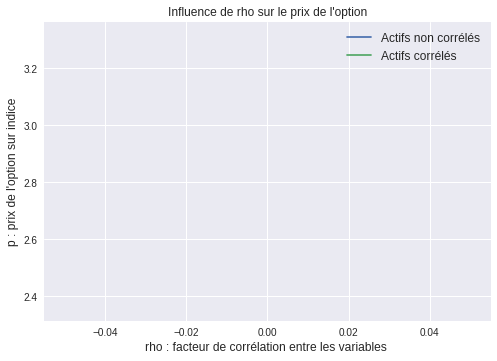

In [24]:
## Influence de rho :

print("\nInfluence du nombre de rho :\n")

plt.figure()
r = 0.05
K = 55
d = 40
sigmas = np.array([[0.2] for i in range(d)])
A = np.identity(d)
x0 = np.ones((d,1)).reshape((d,1))
sigmas = np.array([[0.2] for i in range(d)])        # Sigma des modèles de BS
portofolio = np.array([[1/d for i in range(d)]])
N = 10
h = sqrt(T/(N))
rho_s = np.array([np.linspace(-1/(d-1), 0.9, 20)])
p_n_c = []
p_c = []
for i in tqdm(range(len(rho_s))) :
    rho = rho_s[i]
    G = n_corr_Gn(rho)
    Q = corr_Gn(rho)
    p1 = expectation(G,A,x0,10**(-6))
    print(" ")
    p2 = expectation(Q,A,x0,10**(-6))
    p_n_c.append(p1)
    p_c.append(p2)
plt.plot(rho_s, p_n_c, label="Actifs non corrélés", )
plt.plot(rho_s, p_c, label="Actifs corrélés")
plt.xlabel("rho : facteur de corrélation entre les variables ", fontsize=12)
plt.ylabel("p : prix de l'option sur indice", fontsize=12)
plt.title("Influence de rho sur le prix de l'option")
plt.legend(fontsize=12)
#plt.savefig('rho.eps', format='eps', dpi=1000)
plt.show()

## Comparaison  avec les variances :

In [12]:
def varMC(Gn_T, A, x0, eps=10e-6):
    
    mean = 0
    square = 0
    for i in range(n):
        Gi = Gn_T[:,i]
        Gi = Gi.reshape((-1,1))
        mean += exp(-r*T) * f(Gi)
        square += exp(-r*T) * f(Gi)**2
    Varn = 1/(n-1) * square - (1/n * mean)**2
    
    return Varn
    
def VarRIS(Gn_T, A, x0, Mn, eps=10e-6):

    xn = newton(A, x0, Gn_T, eps)
    xn = xn.reshape((-1,1))

    vn = 0
    for i in range(n):
        Gi = Gn_T[:,i]
        Gi = Gi.reshape((-1,1))
        power = (A.dot(xn).T).dot(Gi) - np.linalg.norm(A.dot(xn))**2/2
        temp = exp(-r*T) * f(Gi)**2 * exp(-power)
        vn += temp
        
    Varn = 1/(n-1)*vn - Mn**2
    return Varn

In [22]:
## Comparaison Variance sans fonction d'imortance et avec :

## Parameters :

d = 40              # actif
r = 0.05            # Facteur d'actualisation
T = 1               # maturite
S0 = 50             # Initialisation des modèles de BS
sigmas = np.array([[0.2] for i in range(d)])        # Sigma des modèles de BS
portofolio = np.array([[1/d for i in range(d)]])    # Répartition entre les différents BS
K = 45                                              # Strike
n = 10000                                           # Nombre de simulations pour Monte-Carlo
N = 100                                             # Nombre de points de discrétisation
rho = 0.1
h = sqrt(T/(N))

x0 = np.ones((d,1)).reshape((d,1))
A = np.identity(d)

rho_s = [0.1, 0.2, .5]
K_s = [50,55]
prices_n_c = []
prices_c = []
Var_MC_nc = []
Var_MC_c = []
Var_RIS_nc = []
Var_RIS_c = []

for rho in rho_s:
    for K in K_s :
        G = n_corr_Gn()
        p1 = expectation(G,A,x0,10**(-6))
        print(" ")
        Q = corr_Gn()
        p2 = expectation(Q,A,x0,10**(-6))
        prices_n_c.append(p1)
        prices_c.append(p2)
        
        Var_MC_nc.append(varMC(G, A, x0))
        Var_MC_c.append(varMC(Q, A, x0))
        
        Var_RIS_nc.append(VarRIS(G, A, x0, p1))
        Var_RIS_c.append(VarRIS(Q, A, x0, p1))
        

for i in range(len(rho_s)):
    print('\n--------------')
    print('rho = ', rho_s[i])
    print("K, Prix nc, , 'Prix c', 'Var_Mc nc', 'Var_Mc c', Var_RIS_nc, var_RIS_c" )
    for j in range(len(K_s)) :
        print("{}  {}  {}  {}  {}  {}  {} ".format(K_s[j], prices_n_c[(i+1)*j], prices_c[(i+1)*j], Var_MC_nc[(i+1)*j], Var_MC_c[(i+1)*j], Var_RIS_nc[(i+1)*j], Var_RIS_c[(i+1)*j]))

Norme du gradient : 10.0019184315
Norme du gradient : 3.25146478858
Norme du gradient : 2.1823948517
Norme du gradient : 1.52611111689
Norme du gradient : 1.56158218643
Norme du gradient : 1.44923999723
Norme du gradient : 1.51774137737
Norme du gradient : 1.45519908852
Norme du gradient : 1.52148769921
Norme du gradient : 1.45494414332
Norme du gradient : 1.52132316442
Norme du gradient : 1.45494507514
Norme du gradient : 1.52132429133
Norme du gradient : 1.4549455924
Norme du gradient : 1.52132459445
 
Norme du gradient : 10.5163630587
Norme du gradient : 3.41282507948
Norme du gradient : 1.52590751831
Norme du gradient : 0.0601843404467
Norme du gradient : 8.4852684819e-05
Norme du gradient : 1.82753576072e-10
Norme du gradient : 10.0019184315
Norme du gradient : 3.25146478858
Norme du gradient : 2.1823948517
Norme du gradient : 1.52611111689
Norme du gradient : 1.56158218643
Norme du gradient : 1.44923999723
Norme du gradient : 1.51774137737
Norme du gradient : 1.45519908852
Norme 